## Air Pollution

Let us use a neural network to predict the air polution at US embassy in Beijing using the following data from UCI MAchine Learning repository: https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [1]:
! wget -c --retry-connrefused --tries=0 https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv -O ~/data/workshop_data/PRSA_data_2010.1.1-2014.12.31.csv

--2019-04-15 21:05:10--  https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2010494 (1.9M) [application/x-httpd-php]
Saving to: ‘/home/ec2-user/data/workshop_data/PRSA_data_2010.1.1-2014.12.31.csv’

/home/ec2-user/data 100%[===================>]   1.92M  7.63MB/s    in 0.3s    

2019-04-15 21:05:13 (7.63 MB/s) - ‘/home/ec2-user/data/workshop_data/PRSA_data_2010.1.1-2014.12.31.csv’ saved [2010494/2010494]



In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch import nn
import torch
import time
import os

home = os.path.expanduser("~")
data = home + '/data/workshop_data/PRSA_data_2010.1.1-2014.12.31.csv'

In [3]:
def parse_date(year, month, day, hour):
    return datetime(int(year), int(month), int(day), int(hour))

In [4]:
df = pd.read_csv(data, parse_dates=[['year', 'month', 'day', 'hour']], date_parser=parse_date)
df = df.drop('No', axis=1)
df.columns = ['date', 'pollution', 'dew_temp', 'temp', 'pressure', 'wind_dir', 'wind_speed', 'snow', 'rain']
df.index = df['date']
df = df.drop('date', axis=1)
df = df[24:]
df['pollution'] = df['pollution'].fillna(df['pollution'].median())
df['wind_dir'] = df['wind_dir'].astype('category').cat.codes

In [5]:
df

pollution  dew_temp  temp  pressure  wind_dir  \
date                                                                 
2010-01-02 00:00:00      129.0       -16  -4.0    1020.0         2   
2010-01-02 01:00:00      148.0       -15  -4.0    1020.0         2   
2010-01-02 02:00:00      159.0       -11  -5.0    1021.0         2   
2010-01-02 03:00:00      181.0        -7  -5.0    1022.0         2   
2010-01-02 04:00:00      138.0        -7  -5.0    1022.0         2   
2010-01-02 05:00:00      109.0        -7  -6.0    1022.0         2   
2010-01-02 06:00:00      105.0        -7  -6.0    1023.0         2   
2010-01-02 07:00:00      124.0        -7  -5.0    1024.0         2   
2010-01-02 08:00:00      120.0        -8  -6.0    1024.0         2   
2010-01-02 09:00:00      132.0        -7  -5.0    1025.0         2   
2010-01-02 10:00:00      140.0        -7  -5.0    1026.0         2   
2010-01-02 11:00:00      152.0        -8  -5.0    1026.0         2   
2010-01-02 12:00:00      148.0        -8  -5.0    1026.0         2   
2010-01-02 13:00:00      164.0        -8  -5.0    1025.0         2   
2010-01-02 14:00:00      158.0        -9  -5.0    1025.0         2   
2010-01-02 15:00:00      154.0        -9  -5.0    1025.0         2   
2010-01-02 16:00:00      159.0        -9  -5.0    1026.0         2   
2010-01-02 17:00:00      164.0        -8  -5.0    1027.0         2   
2010-01-02 18:00:00      170.0        -8  -5.0    1027.0         2   
2010-01-02 19:00:00      149.0        -8  -5.0    1028.0         2   
2010-01-02 20:00:00      154.0        -7  -5.0    1028.0         2   
2010-01-02 21:00:00      164.0        -7  -5.0    1027.0         2   
2010-01-02 22:00:00      156.0        -8  -6.0    1028.0         2   
2010-01-02 23:00:00      126.0        -8  -6.0    1027.0         2   
2010-01-03 00:00:00       90.0        -7  -6.0    1027.0         2   
2010-01-03 01:00:00       63.0        -8  -6.0    1026.0         2   
2010-01-03 02:00:00       65.0        -8  -7.0    1026.0         2   
2010-01-03 03:00:00       55.0        -8  -7.0    1025.0         2   
2010-01-03 04:00:00       65.0        -8  -7.0    1024.0         2   
2010-01-03 05:00:00       83.0        -9  -8.0    1024.0         2   
...                        ...       ...   ...       ...       ...   
2014-12-30 18:00:00       79.0       -13   2.0    1020.0         0   
2014-12-30 19:00:00       35.0        -8   6.0    1021.0         1   
2014-12-30 20:00:00       26.0       -11   5.0    1022.0         1   
2014-12-30 21:00:00       20.0       -12   4.0    1023.0         1   
2014-12-30 22:00:00        8.0       -21   2.0    1025.0         1   
2014-12-30 23:00:00       16.0       -22   0.0    1026.0         1   
2014-12-31 00:00:00       10.0       -19  -1.0    1027.0         1   
2014-12-31 01:00:00       11.0       -18  -1.0    1028.0         1   
2014-12-31 02:00:00       20.0       -17  -1.0    1028.0         1   
2014-12-31 03:00:00        9.0       -17  -1.0    1029.0         1   
2014-12-31 04:00:00        8.0       -19  -2.0    1030.0         1   
2014-12-31 05:00:00        9.0       -21  -3.0    1030.0         1   
2014-12-31 06:00:00        8.0       -23  -4.0    1032.0         1   
2014-12-31 07:00:00        8.0       -22  -5.0    1034.0         1   
2014-12-31 08:00:00        8.0       -22  -5.0    1034.0         1   
2014-12-31 09:00:00        8.0       -22  -3.0    1034.0         1   
2014-12-31 10:00:00        7.0       -22  -2.0    1034.0         1   
2014-12-31 11:00:00       12.0       -22  -2.0    1034.0         1   
2014-12-31 12:00:00       17.0       -22   0.0    1033.0         1   
2014-12-31 13:00:00       11.0       -27   0.0    1032.0         1   
2014-12-31 14:00:00        9.0       -27   1.0    1032.0         1   
2014-12-31 15:00:00       11.0       -26   1.0    1032.0         1   
2014-12-31 16:00:00        8.0       -23   0.0    1032.0         1   
2014-12-31 17:00:00        9.0       -22  -1.0    1033.0         1   
2014-12-31 18:00:00       10.0 

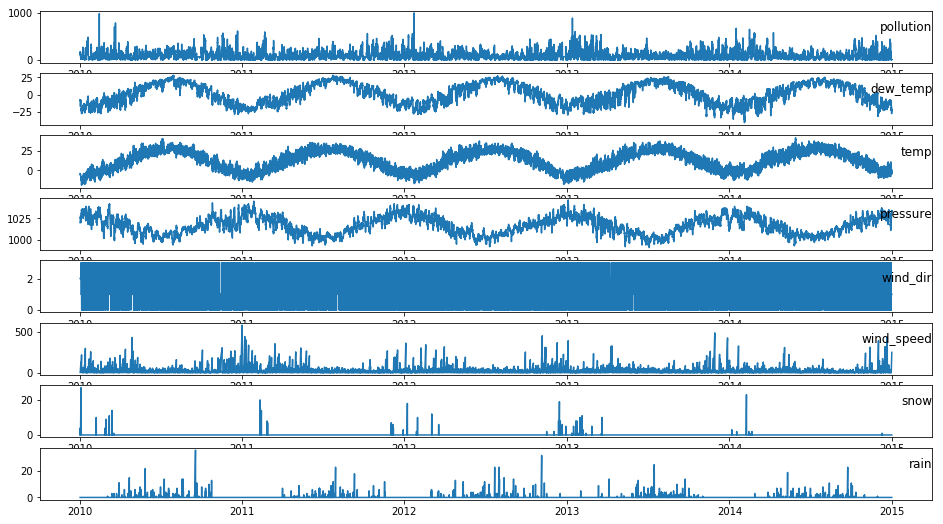

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,9))
for i in range(len(df.columns)):
    plt.subplot(len(df.columns), 1, i+1)
    plt.plot(df[df.columns[i]])
    plt.title(df.columns[i], loc='right', y =.5)

## Target
We want to predict the olusion in the next our, given the previous context data.
So let us first add a target column:

In [7]:
df['target'] = df['pollution'].shift(-1)
df = df[:-1]
features = [col for col in df.columns if col != 'target']

## Train, Test
We can not shuffle the data for random splits anymore, as we will train sequentailly.
Therefore, we define a date at which we split the data:

In [8]:
train_end = datetime(2014, 1, 1)
#val_end = datetime(2014, 7, 1)
train = df[:train_end]
#val = df[train_end:val_end]
test = df[train_end:]

In [9]:
def window_nd(a, window, steps = None, axis = None, outlist = False):
        """
        Create a windowed view over `n`-dimensional input that uses an 
        `m`-dimensional window, with `m <= n`.
        
    
        Parameters
        -------------
        a : Array-like
            The array to create the view on
    
        window : tuple or int
            If int, the size of the window in `axis`, or in all dimensions if 
            `axis == None`
    
            If tuple, the shape of the desired window.  `window.size` must be:
                equal to `len(axis)` if `axis != None`, else 
                equal to `len(a.shape)`, or 
                1
    
        steps : tuple, int or None
            The offset between consecutive windows in desired dimension
            If None, offset is one in all dimensions
            If int, the offset for all windows over `axis`
            If tuple, the steps along each `axis`.  
                `len(steps)` must me equal to `len(axis)`
    
        axis : tuple, int or None
            The axes over which to apply the window
            If None, apply over all dimensions
            if tuple or int, the dimensions over which to apply the window
    
        outlist : boolean
            If output should be as list of windows.  
            If False, it will be an array with 
                `a.nidim + 1 <= a_view.ndim <= a.ndim *2`.  
            If True, output is a list of arrays with `a_view[0].ndim = a.ndim`
                Warning: this is a memory-intensive copy and not a view
    
        Returns
        -------
    
        a_view : ndarray
            A windowed view on the input array `a`, or copied list of windows   
    
        """
        ashp = np.array(a.shape)
    
        if axis != None:
            axs = np.array(axis, ndmin = 1)
            assert np.all(np.in1d(axs, np.arange(ashp.size))), "Axes out of range"
        else:
            axs = np.arange(ashp.size)
    
        window = np.array(window, ndmin = 1)
        assert (window.size == axs.size) | (window.size == 1), "Window dims and axes don't match"
        wshp = ashp.copy()
        wshp[axs] = window
        assert np.all(wshp <= ashp), "Window is bigger than input array in axes"
    
        stp = np.ones_like(ashp)
        if steps:
            steps = np.array(steps, ndmin = 1)
            assert np.all(steps > 0), "Only positive steps allowed"
            assert (steps.size == axs.size) | (steps.size == 1), "Steps and axes don't match"
            stp[axs] = steps
    
        astr = np.array(a.strides)
        shape = tuple((ashp - wshp) // stp + 1) + tuple(wshp)
        strides = tuple(astr * stp) + tuple(astr)
    
        as_strided = np.lib.stride_tricks.as_strided
        a_view = np.squeeze(as_strided(a, 
                                     shape = shape, 
                                     strides = strides))
        #print(astr, strides, shape, a_view)
        if outlist:
            return list(a_view.reshape((-1,) + tuple(wshp)))
        else:
            return a_view

## Scale
Neural networks work best if the data have the same input scale. To achieve this, we will use sklearn's MinMaxScaler:

In [16]:
df = df.astype(np.float32)
scaler = MinMaxScaler()
past_samples = 10
x_train = window_nd(scaler.fit_transform(train[features]), past_samples, 1, axis=0)
x_test = window_nd(scaler.transform(test[features]), past_samples, 1, axis=0)
y_train = scaler.fit_transform(train['target'].values.reshape(-1, 1))
y_test = scaler.transform(test['target'].values.reshape(-1, 1))

In [17]:
x_train[0]

array([[0.12977867, 0.27868852, 0.25      , 0.52727273, 0.66666667,
        0.00229001, 0.        , 0.        ],
       [0.14889336, 0.29508197, 0.25      , 0.52727273, 0.66666667,
        0.00381099, 0.        , 0.        ],
       [0.15995976, 0.36065574, 0.23333333, 0.54545455, 0.66666667,
        0.00533197, 0.        , 0.        ],
       [0.18209256, 0.42622951, 0.23333333, 0.56363636, 0.66666667,
        0.00839101, 0.03703704, 0.        ],
       [0.138833  , 0.42622951, 0.23333333, 0.56363636, 0.66666667,
        0.00991199, 0.07407407, 0.        ],
       [0.10965795, 0.42622951, 0.21666667, 0.56363636, 0.66666667,
        0.01143297, 0.11111111, 0.        ],
       [0.1056338 , 0.42622951, 0.21666667, 0.58181818, 0.66666667,
        0.01449201, 0.14814815, 0.        ],
       [0.12474849, 0.42622951, 0.23333333, 0.6       , 0.66666667,
        0.01755106, 0.        , 0.        ],
       [0.12072435, 0.40983607, 0.21666667, 0.6       , 0.66666667,
        0.0206101 , 0.      

Let us start by building a [recurrent neural network](https://pytorch.org/docs/stable/nn.html#torch.nn.RNN). 
We will put the output of the recurrent layer through an activation function into a linear layer to get a single value from it. 

In [18]:
class RNNNet(nn.Module):
    
    def __init__(self, number_of_inputs, hidden_size, num_layers):
        super().__init__()
        # Build the recurrent parts using nn.RNN
        self.rnn = nn.RNN(number_of_inputs, hidden_size, num_layers)
        # Use a ReLU as an activation
        self.act = nn.ReLU()
        # Use a linear output layer
        self.out = nn.Linear(hidden_size, 1)
    
    def forward(self, inp):
        # implement the rest of the forward function
        output, x = self.rnn(inp)
        print(output.shape, x.shape)
        x = self.act(x[-1])
        return self.out(x)

In [19]:
def fit_batch(optim, loss, net, x, y):
    optim.zero_grad()
    y_pred = net(x)
    err = loss(y_pred, y)
    err.mean().backward()
    optim.step()
    return y_pred, err

In [20]:
torch.cuda.manual_seed(42)
np.random.seed(42)
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
batch_size = 128 # this is used to determine how many random items from the data we want to use in order to train
# epoch is when you think you've gone through the data set
# With tons of available data, you have to decide when you think you've hit the epoch even though you don't have the
#     time or resources to go through the entire set to train
batches_per_epoch = 5 
epochs = 20
net = RNNNet(x_train.shape[-1], 25, 1).to(device)
loss = nn.L1Loss()
optim = torch.optim.Adam(net.parameters(), lr=5e-4)
start = time.time()  
for epoch in range(epochs):
    train_err = None
    for j in range(batches_per_epoch):
        select = np.random.randint(0, len(x_train), batch_size)
        x = torch.from_numpy(x_train[select]).float().to(device)
        y = torch.from_numpy(y_train[select]).float().unsqueeze(1).to(device)
        y_pred, err = fit_batch(optim, loss, net, x, y)
        if train_err is None:
            train_err = err
        else:
            train_err += err
        #y_pred = y_pred.argmax(dim=-1)
        #acc += (y==y_pred).float().mean()
    x = torch.from_numpy(x_test).float().to(device)
    y = torch.from_numpy(y_test).float().unsqueeze(1).to(device)
    y_pred = net(x)
    test_err = loss(y_pred, y)
    print(f'Epoch {epoch} train_loss {train_err/batches_per_epoch} test_loss {test_err}')
print(f'Training time: {time.time() - start}')

torch.Size([128, 10, 25]) torch.Size([1, 10, 25])
torch.Size([128, 10, 25]) torch.Size([1, 10, 25])
torch.Size([128, 10, 25]) torch.Size([1, 10, 25])
torch.Size([128, 10, 25]) torch.Size([1, 10, 25])
torch.Size([128, 10, 25]) torch.Size([1, 10, 25])
torch.Size([8750, 10, 25]) torch.Size([1, 10, 25])
Epoch 0 train_loss 0.3170665204524994 test_loss 0.26318836212158203
torch.Size([128, 10, 25]) torch.Size([1, 10, 25])
torch.Size([128, 10, 25]) torch.Size([1, 10, 25])
torch.Size([128, 10, 25]) torch.Size([1, 10, 25])
torch.Size([128, 10, 25]) torch.Size([1, 10, 25])
torch.Size([128, 10, 25]) torch.Size([1, 10, 25])
torch.Size([8750, 10, 25]) torch.Size([1, 10, 25])
Epoch 1 train_loss 0.24513795971870422 test_loss 0.19033850729465485
torch.Size([128, 10, 25]) torch.Size([1, 10, 25])
torch.Size([128, 10, 25]) torch.Size([1, 10, 25])
torch.Size([128, 10, 25]) torch.Size([1, 10, 25])
torch.Size([128, 10, 25]) torch.Size([1, 10, 25])
torch.Size([128, 10, 25]) torch.Size([1, 10, 25])
torch.Size(

Let us now use an [LSTM](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM) instead of a simple RNN.

In [23]:
class LSTMNet(nn.Module):
    
    def __init__(self, number_of_inputs, hidden_size, num_layers):
        super().__init__()
        # Build the recurrent parts using nn.RNN
        self.lstm = nn.LSTM(number_of_inputs, hidden_size, num_layers)
        # Use a ReLU as an activation
        self.act = nn.ReLU()
        # Use a linear output layer
        self.out = nn.Linear(hidden_size, 1)
    
    def forward(self, inp):
        # implement the rest of the forward function
        output, x = self.lstm(inp)
        x = self.act(x[0][-1])
        return self.out(x)

In [24]:
torch.cuda.manual_seed(42)
np.random.seed(46)
net = LSTMNet(x_train.shape[-1], 25, 1).to(device)
optim = torch.optim.Adam(net.parameters(), lr=5e-4)
start = time.time()  
for epoch in range(epochs):
    train_err = None
    for j in range(batches_per_epoch):
        select = np.random.randint(0, len(x_train), batch_size)
        x = torch.from_numpy(x_train[select]).float().to(device)
        y = torch.from_numpy(y_train[select]).float().unsqueeze(1).to(device)
        y_pred, err = fit_batch(optim, loss, net, x, y)
        if train_err is None:
            train_err = err
        else:
            train_err += err
        #y_pred = y_pred.argmax(dim=-1)
        #acc += (y==y_pred).float().mean()
    x = torch.from_numpy(x_test).float().to(device)
    y = torch.from_numpy(y_test).float().unsqueeze(1).to(device)
    y_pred = net(x)
    test_err = loss(y_pred, y)
    print(f'Epoch {epoch} train_loss {train_err/batches_per_epoch} test_loss {test_err}')
print(f'Training time: {time.time() - start}')

Epoch 0 train_loss 0.08929162472486496 test_loss 0.08714823424816132
Epoch 1 train_loss 0.08361353725194931 test_loss 0.08091825246810913
Epoch 2 train_loss 0.07773467153310776 test_loss 0.07559827715158463
Epoch 3 train_loss 0.07305420190095901 test_loss 0.07131477445363998
Epoch 4 train_loss 0.06848073750734329 test_loss 0.06807532161474228
Epoch 5 train_loss 0.06305854767560959 test_loss 0.06601875275373459
Epoch 6 train_loss 0.06283196061849594 test_loss 0.06513995677232742
Epoch 7 train_loss 0.0629153847694397 test_loss 0.06521423161029816
Epoch 8 train_loss 0.06593529134988785 test_loss 0.06551489233970642
Epoch 9 train_loss 0.05966247245669365 test_loss 0.0655699148774147
Epoch 10 train_loss 0.06377303600311279 test_loss 0.06536513566970825
Epoch 11 train_loss 0.06744767725467682 test_loss 0.06511242687702179
Epoch 12 train_loss 0.05856006219983101 test_loss 0.06507186591625214
Epoch 13 train_loss 0.0634692832827568 test_loss 0.06507717818021774
Epoch 14 train_loss 0.06549086421

As we are overfitting, let us add [dropout](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) to the LSTM network:

In [27]:
class LSTMNetWithDropout(nn.Module):
    
    def __init__(self, number_of_inputs, hidden_size, num_layers, dropout):
        super().__init__()
        # Build the recurrent parts using nn.RNN
        self.lstm = nn.LSTM(number_of_inputs, hidden_size, num_layers)
        # Use a ReLU as an activation
        self.act = nn.ReLU()
        # Use a linear output layer
        self.out = nn.Linear(hidden_size, 1)
        # Build the recurrent parts using nn.RNN
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # implement the rest of the forward function
        output, x = self.lstm(inp)
        x = self.act(self.dropout(x[0][-1]))
        return self.out(x)

In [28]:
torch.cuda.manual_seed(42)
np.random.seed(42)
net = LSTMNetWithDropout(x_train.shape[-1], 25, 1, .2).to(device)
optim = torch.optim.Adam(net.parameters(), lr=5e-4)
start = time.time()  
batches_per_epoch_new = batches_per_epoch * 4
for epoch in range(epochs):
    train_err = None
    for j in range(batches_per_epoch_new):
        select = np.random.randint(0, len(x_train), batch_size)
        x = torch.from_numpy(x_train[select]).float().to(device)
        y = torch.from_numpy(y_train[select]).float().unsqueeze(1).to(device)
        y_pred, err = fit_batch(optim, loss, net, x, y)
        if train_err is None:
            train_err = err
        else:
            train_err += err
        #y_pred = y_pred.argmax(dim=-1)
        #acc += (y==y_pred).float().mean()
    x = torch.from_numpy(x_test).float().to(device)
    y = torch.from_numpy(y_test).float().unsqueeze(1).to(device)
    y_pred = net(x)
    test_err = loss(y_pred, y)
    print(f'Epoch {epoch} train_loss {train_err/batches_per_epoch_new} test_loss {test_err}')
print(f'Training time: {time.time() - start}')

Epoch 0 train_loss 0.1219637393951416 test_loss 0.09628133475780487
Epoch 1 train_loss 0.07497250288724899 test_loss 0.06628827005624771
Epoch 2 train_loss 0.07115112245082855 test_loss 0.06910355389118195
Epoch 3 train_loss 0.06487634032964706 test_loss 0.06704586744308472
Epoch 4 train_loss 0.06778376549482346 test_loss 0.07197696715593338
Epoch 5 train_loss 0.07018988579511642 test_loss 0.06913934648036957
Epoch 6 train_loss 0.0693347156047821 test_loss 0.06834769248962402
Epoch 7 train_loss 0.06388068199157715 test_loss 0.07314809411764145
Epoch 8 train_loss 0.06818664073944092 test_loss 0.06995544582605362
Epoch 9 train_loss 0.06652188301086426 test_loss 0.06923011690378189
Epoch 10 train_loss 0.06774415820837021 test_loss 0.07108045369386673
Epoch 11 train_loss 0.0670083612203598 test_loss 0.0678245797753334
Epoch 12 train_loss 0.06760817766189575 test_loss 0.06747308373451233
Epoch 13 train_loss 0.06629936397075653 test_loss 0.07204008102416992
Epoch 14 train_loss 0.063858129084